## Bias correction ERA5

Based on script from Shijie Shi here: https://github.com/goose888/FATES_MRV/blob/main/Generate_climate_forcings.ipynb

In [1]:
import netCDF4 as nc4
import numpy as np
from matplotlib import pyplot as plt
import copy
import pandas as pd
import time
import xarray as xr
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import cm
import matplotlib.colors as mcolors
from matplotlib.colors import Normalize
from matplotlib.colors import BoundaryNorm


/global/homes/j/jneedham/.conda/envs/myenv/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Read in the climate data and extract the PA grid cell 

In [2]:
# Parameters for calculating vapor pressure
a1=6.107799961
a2=4.436518521e-1
a3=1.428945805e-2
a4=2.650648471e-4
a5=3.031240396e-6
a6=2.034080948e-8
a7=6.136820929e-11

In [3]:
lat = 41.05734
lon = -78.69149

if lon < 0 : 
     lon = 360 + lon
     print(lon)

281.30851


In [5]:
yrs = np.arange(1980, 2023, 1).tolist()
months = np.arange(1,13,1).tolist()

print(months)
print(yrs)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
[1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]


In [6]:
for yr in yrs  :
    print(yr)
    for  mon in months : 
        
        # Tbot
        tbot_full = '/global/cfs/cdirs/e3sm/inputdata/atm/datm7/atm_forcing.datm7.ERA.0.25d.v5.c180614/tbot/elmforc.ERA5.c2018.0.25d.t2m.{}-{:02d}.nc'.format(yr, mon)
        tbot_full = xr.open_dataset(tbot_full, decode_times=False)

        lon_mids = tbot_full.LONGXY[0,0:1440] 
        lat_mids = tbot_full.LATIXY[0:721,0]

        abslat = np.abs(lat_mids - lat)
        abslon = np.abs(lon_mids - lon)
        c = np.maximum(abslon, abslat)
         
        ([xloc],[yloc]) = np.where(c == np.min(c))
        
        lat_new = lat_mids[yloc]
        lon_new = lon_mids[xloc]
        
        tbot = tbot_full.isel(lon=[xloc],lat=[yloc])
        tbot = tbot.rename({'t2m':'TBOT'})
        
        # Precipitation mm/s
        prec_full = '/global/cfs/cdirs/e3sm/inputdata/atm/datm7/atm_forcing.datm7.ERA.0.25d.v5.c180614/prec/elmforc.ERA5.c2018.0.25d.mcpr.{}-{:02d}.nc'.format(yr, mon)
        prec_full = xr.open_dataset(prec_full, decode_times=False)
        prec = prec_full.isel(lon=[xloc],lat=[yloc])
        
        prel_full = '/global/cfs/cdirs/e3sm/inputdata/atm/datm7/atm_forcing.datm7.ERA.0.25d.v5.c180614/prec/elmforc.ERA5.c2018.0.25d.mlspr.{}-{:02d}.nc'.format(yr, mon)
        prel_full = xr.open_dataset(prel_full, decode_times=False)
        prel = prel_full.isel(lon=[xloc],lat=[yloc])
        
        prec['mcpr'] = prec.mcpr + prel.mlspr
        prec = prec.rename({'mcpr':'PRECTmms'})
        
        # Wind speed 10 m wind speed, m s-1
        w10_full = '/global/cfs/cdirs/e3sm/inputdata/atm/datm7/atm_forcing.datm7.ERA.0.25d.v5.c180614/wind/elmforc.ERA5.c2018.0.25d.w10.{}-{:02d}.nc'.format(yr, mon)
        w10_full = xr.open_dataset(w10_full, decode_times=False)
        w10 = w10_full.isel(lon=[xloc],lat=[yloc])
        w10 = w10.rename({'w10':'WIND'})
        
        # Radiation W m-2
        rad_full = '/global/cfs/cdirs/e3sm/inputdata/atm/datm7/atm_forcing.datm7.ERA.0.25d.v5.c180614/swdn/elmforc.ERA5.c2018.0.25d.msdwswrf.{}-{:02d}.nc'.format(yr, mon)
        rad_full = xr.open_dataset(rad_full, decode_times=False)
        rad = rad_full.isel(lon=[xloc],lat=[yloc])
        rad = rad.rename({'msdwswrf':'FSDS'})
        
        # Longwave radiation W m-2
        lwrad_full = '/global/cfs/cdirs/e3sm/inputdata/atm/datm7/atm_forcing.datm7.ERA.0.25d.v5.c180614/lwdn/elmforc.ERA5.c2018.0.25d.msdwlwrf.{}-{:02d}.nc'.format(yr, mon)
        lwrad_full = xr.open_dataset(lwrad_full, decode_times=False)
        lwrad = lwrad_full.isel(lon=[xloc],lat=[yloc])
        lwrad = lwrad.rename({'msdwlwrf':'FLDS'})
        
        # Dew point Temp, K
        tdew_full = '/global/cfs/cdirs/e3sm/inputdata/atm/datm7/atm_forcing.datm7.ERA.0.25d.v5.c180614/tdew/elmforc.ERA5.c2018.0.25d.d2m.{}-{:02d}.nc'.format(yr, mon)
        tdew_full = xr.open_dataset(tdew_full, decode_times=False)
        tdew = tdew_full.isel(lon=[xloc],lat=[yloc])
        
        # Surface pressure, Pa
        sp_full = '/global/cfs/cdirs/e3sm/inputdata/atm/datm7/atm_forcing.datm7.ERA.0.25d.v5.c180614/pbot/elmforc.ERA5.c2018.0.25d.sp.{}-{:02d}.nc'.format(yr, mon)
        sp_full = xr.open_dataset(sp_full, decode_times=False)
        sp = sp_full.isel(lon=[xloc],lat=[yloc])
        sp = sp.rename({'sp':'PSRF'})
        
        # Transfer dew point and temperature to relative humidity
        dew = tdew.d2m - 273.16
        tair = tbot.TBOT - 273.16
        ea = a1 +dew*(a2+dew*(a3+dew*(a4+dew*(a5+dew*(a6+dew*a7)))))
        es = a1 +tair*(a2+tair*(a3+tair*(a4+tair*(a5+tair*(a6+tair*a7)))))
        rh_era = ea/(es+1e-10)
        rh_era = rh_era.to_dataset(name='RH')
        
        combined = xr.merge([tbot, prec, w10, rad, lwrad, sp, rh_era])
        
        combined.to_netcdf('/pscratch/sd/j/jneedham/fates-mrv-runs/climate-forcing/PA/ERA5/non_corr/{}-{:02d}.nc'.format(yr, mon))

1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022


### Read in terraclimate dataset

   Year  Month  tmax(degC)  tmin(degC)  ppt(mm)  ws(mps)
0  1980      1       -0.12       -8.94     29.5     4.01
1  1980      2       -1.59      -10.72     27.8     3.81
2  1980      3        4.59       -6.12    113.6     4.30


Text(0.5, 0, 'Time (years)')

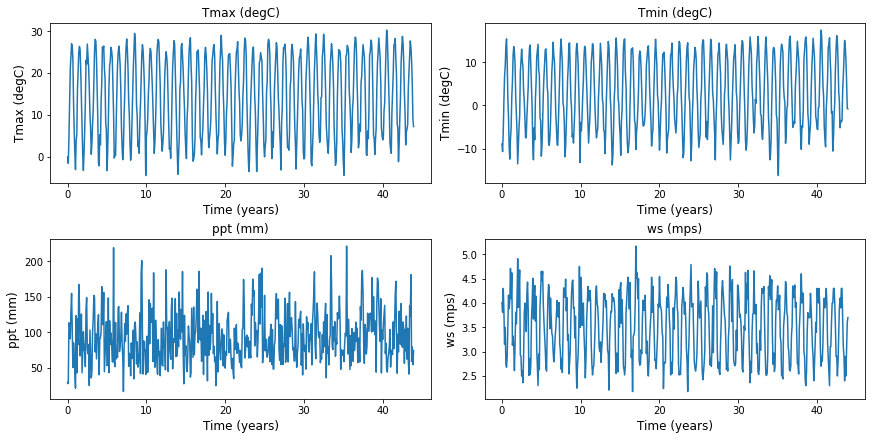

In [7]:
# Read in terraclimate data - single point data downloaded from : 
# https://climate.northwestknowledge.net/NWTOOLBOX/formattedDownloads.php

terra = pd.read_csv('/pscratch/sd/j/jneedham/fates-mrv-runs/climate-forcing/Terraclimate/terraclimate_41.05734N_78.69149W_formatted.csv')
print(terra.head(3))

yrs = np.arange(0,len(terra),1) / 12

# quick plots as a sanity check for weird values - whole time series
fig1, ((f1ax0, f1ax1),(f1ax2, f1ax3)) = plt.subplots(nrows=2,ncols=2, figsize=(12,6), constrained_layout=True)

f1ax0.plot(yrs, terra['tmax(degC)'])    
f1ax1.plot(yrs, terra['tmin(degC)'])
f1ax2.plot(yrs, terra['ppt(mm)'])
f1ax3.plot(yrs, terra['ws(mps)'])

f1ax0.set_title(r'Tmax (degC)', fontsize = 12)
f1ax0.set_ylabel(r'Tmax (degC)', fontsize = 12)
f1ax0.set_xlabel(r'Time (years)', fontsize = 12)    
f1ax1.set_title(r'Tmin (degC)', fontsize = 12)
f1ax1.set_ylabel(r'Tmin (degC)', fontsize = 12)
f1ax1.set_xlabel(r'Time (years)', fontsize = 12)    
f1ax2.set_title(r'ppt (mm)', fontsize = 12)
f1ax2.set_ylabel(r'ppt (mm)', fontsize = 12)
f1ax2.set_xlabel(r'Time (years)', fontsize = 12)    
f1ax3.set_title(r'ws (mps)', fontsize = 12)
f1ax3.set_ylabel(r'ws (mps)', fontsize = 12)
f1ax3.set_xlabel(r'Time (years)', fontsize = 12)    

Text(0.5, 0, 'Time (months)')

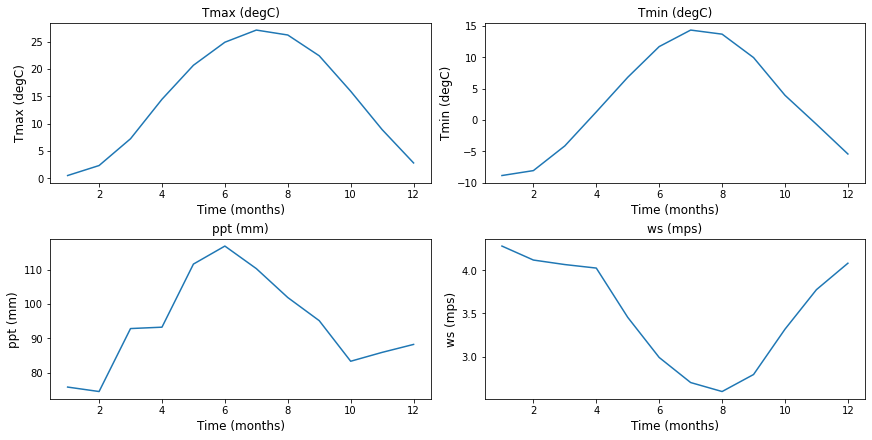

In [8]:
tmin_seasonal = terra.groupby('Month')['tmin(degC)'].mean()
tmax_seasonal = terra.groupby('Month')['tmax(degC)'].mean()
ppt_seasonal = terra.groupby('Month')['ppt(mm)'].mean()
ws_seasonal = terra.groupby('Month')['ws(mps)'].mean()

mons = np.arange(1,13,1)

# quick plots as a sanity check  - seasonal cycle
fig1, ((f1ax0, f1ax1),(f1ax2, f1ax3)) = plt.subplots(nrows=2,ncols=2, figsize=(12,6), constrained_layout=True)


f1ax0.plot(mons, tmax_seasonal)    
f1ax1.plot(mons, tmin_seasonal)
f1ax2.plot(mons, ppt_seasonal)
f1ax3.plot(mons, ws_seasonal)

f1ax0.set_title(r'Tmax (degC)', fontsize = 12)
f1ax0.set_ylabel(r'Tmax (degC)', fontsize = 12)
f1ax0.set_xlabel(r'Time (months)', fontsize = 12)    
f1ax1.set_title(r'Tmin (degC)', fontsize = 12)
f1ax1.set_ylabel(r'Tmin (degC)', fontsize = 12)
f1ax1.set_xlabel(r'Time (months)', fontsize = 12)    
f1ax2.set_title(r'ppt (mm)', fontsize = 12)
f1ax2.set_ylabel(r'ppt (mm)', fontsize = 12)
f1ax2.set_xlabel(r'Time (months)', fontsize = 12)    
f1ax3.set_title(r'ws (mps)', fontsize = 12)
f1ax3.set_ylabel(r'ws (mps)', fontsize = 12)
f1ax3.set_xlabel(r'Time (months)', fontsize = 12) 
   

In [9]:
# For each month we get the maximum and minimum temperature and calculate the mean of that month.
# Use the difference between TerraClimate and ERA5 to correct the temperature
# Same method is applied to correct wind speed.
# Before correcting temperature bias, dew point temperature must be transferred into either specific or relative humidity.
# Currently we just use linear scaling (Chen et al., 2022)

# Daymet data from: https://daymet.ornl.gov/single-pixel/

yrs = np.arange(1980, 2023, 1).tolist()
months = np.arange(1,13,1).tolist()

jday_beg = [0, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334]
jday_end = [31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334, 365]


# tmin monthly mean - ERA5
for yr in yrs  :
    for  mon in months : 
        
        era = '/pscratch/sd/j/jneedham/fates-mrv-runs/climate-forcing/PA/ERA5/non_corr/{}-{:02d}.nc'.format(yr, mon)
        era = xr.open_dataset(era)
        
        # get the max and min over each 24 hour period - then take the mean
        tbot_max = era.TBOT.resample(time='1D').max().mean().values
        tbot_min = era.TBOT.resample(time='1D').min().mean().values
        
        # correct by the mean tmax and tmin from Terra climate
        terra_tmax = terra[(terra['Year'] == yr) & (terra['Month'] == mon)]['tmax(degC)'].values
        terra_tmin = terra[(terra['Year'] == yr) & (terra['Month'] == mon)]['tmin(degC)'].values
        
        corr_tbot = (terra_tmax+273.16 - tbot_max + terra_tmin+273.16 - tbot_min) / 2.0
        
        era['TBOT'] = era.TBOT + corr_tbot
        
        # for wind take the mean over the month
        wind_mean = era.WIND.mean().values
        terra_wind = terra[(terra['Year'] == yr) & (terra['Month'] == mon)]['ws(mps)'].values
        corr_wind = terra_wind - wind_mean
        era['WIND'] = era.WIND + corr_wind
        
        # use daymet actual vapour pressure to adjust RH
        rh = era.RH
        
        tair = era['TBOT'] - 273.16
        es = a1 +tair*(a2+tair*(a3+tair*(a4+tair*(a5+tair*(a6+tair*a7)))))
        ea = np.squeeze(es * rh)
        ea_daily = np.squeeze(ea.resample(time='1D').mean().values) 
        
        
        fp = '/pscratch/sd/j/jneedham/fates-mrv-runs/climate-forcing/DayMet/11751_lat_41.05734_lon_-78.69149_2024-10-01_183151_formatted.csv'
        df_daymet = pd.read_csv(fp)
        df_daymet_yr = df_daymet[(df_daymet['year'] == yr)]
        df_daymet_mon = df_daymet_yr[jday_beg[mon-1]:jday_end[mon-1]]
        ea_daymet = np.squeeze(df_daymet_mon['vp (Pa)'].values)
              
        corr_ea = (ea_daymet * 0.01) - ea_daily
        corr_ea_hrly = np.repeat(corr_ea, 24)
        ea = ea + corr_ea_hrly
        rh = ea / es * 100
        era['RH'] = rh
             
            
        era.to_netcdf('/pscratch/sd/j/jneedham/fates-mrv-runs/PA/CLM1PT_data/{}-{:02d}.nc'.format(yr, mon))

### Plots to validate 

In [11]:
# Read in data and make plot to validate
# Obtain TerraClimate data
yrbeg = 1980
yrend = 2023
nlen = 12 * (yrend - yrbeg)

tmax_era = np.zeros((nlen))
tmin_era = np.zeros((nlen))
wmean_era = np.zeros((nlen))

for i in np.arange(yrbeg,yrend):
    for j in np.arange(1,13):
        
        era = '/pscratch/sd/j/jneedham/fates-mrv-runs/PA/CLM1PT_data/{}-{:02d}.nc'.format(i, j)
        era = xr.open_dataset(era)
        
        tbot_era = era['TBOT']
        wind_era = era['WIND']
        rh_era = era['RH']
        
        pbeg = (i-yrbeg)*12+j-1
        tmax_era[pbeg] = tbot_era.resample(time='1D').max().mean().values
        tmin_era[pbeg] = tbot_era.resample(time='1D').min().mean().values
        wmean_era[pbeg] = wind_era.mean().values
        
       # tair = tbot_era - 273.16
       # es_era = a1 + tair * (a2 + tair * (a3 + tair * (a4 + tair * (a5 + tair * (a6 + tair * a7)))))
       # ea_era[pbeg] = np.nanmean(rh_era * es_era)


In [14]:
terra_sub = terra[0:12*43]

Text(0, 0.5, 'T max (deg c)')

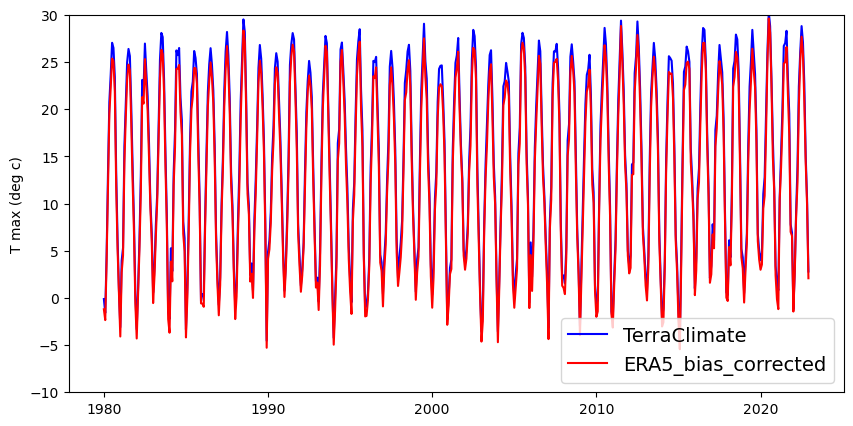

In [15]:
# Comparison Tmax 
yr_axis = np.arange(1980, 2023, 1.0/12.0)
plot_len = len(yr_axis)
fig = plt.figure(figsize=(10,5), dpi=100)
plt.plot(yr_axis, terra_sub['tmax(degC)'], 'b-')
plt.plot(yr_axis, tmax_era-273.16, 'r-')
plt.legend(['TerraClimate', 'ERA5_bias_corrected'], fontsize = 14)
plt.ylim([-10, 30])
plt.ylabel('T max (deg c)')

Text(0, 0.5, 'T min (deg c)')

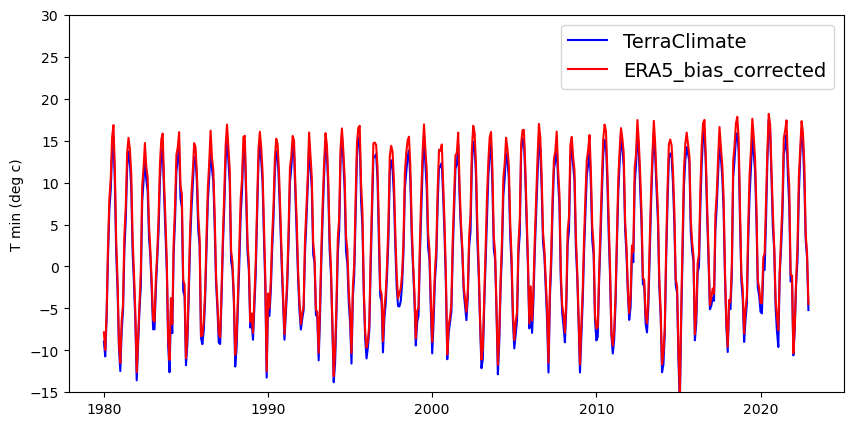

In [16]:
# Comparison Tmin
fig = plt.figure(figsize=(10,5), dpi=100)
plt.plot(yr_axis, terra_sub['tmin(degC)'], 'b-')
plt.plot(yr_axis, tmin_era-273.16, 'r-')
plt.legend(['TerraClimate', 'ERA5_bias_corrected'], fontsize = 14)
plt.ylim([-15, 30])
plt.ylabel('T min (deg c)')

Text(0, 0.5, 'Wind speed (mps)')

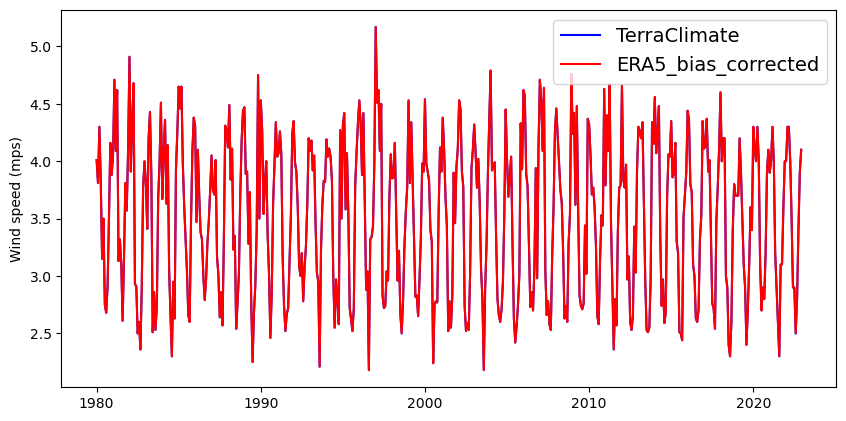

In [17]:
# Comparison wind speed
fig = plt.figure(figsize=(10,5), dpi=100)
plt.plot(yr_axis, terra_sub['ws(mps)'], 'b-')
plt.plot(yr_axis, wmean_era, 'r-')
plt.legend(['TerraClimate', 'ERA5_bias_corrected'], fontsize = 14)
#plt.ylim([-15, 30])
plt.ylabel('Wind speed (mps)')

### Relative humidity
Daymet data is daily so convert ERA5 to daily values

In [19]:
yrbeg = 1980
yrend = 2023
nlen = 365 * (yrend - yrbeg)

ea_era_daily = np.zeros((nlen))

mlen = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
jday_beg = [0, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334]


for i in np.arange(yrbeg,yrend):
    for j in np.arange(1,13):
        
        era = '/pscratch/sd/j/jneedham/fates-mrv-runs/PA/CLM1PT_data/{}-{:02d}.nc'.format(i, j)
        era = xr.open_dataset(era)
        
        tbot_era = era['TBOT']
        rh_era = era['RH']
        
        pbeg = (i-yrbeg)*365 + jday_beg[j-1]
        pend = pbeg + mlen[j-1]
        
        
        tair = tbot_era - 273.16
        es_era = a1 + tair * (a2 + tair * (a3 + tair * (a4 + tair * (a5 + tair * (a6 + tair * a7)))))
        ea_era = es_era * rh_era
        
        tmp = np.squeeze(ea_era.resample(time='1D').mean().values)
        ea_era_daily[pbeg:pend] = tmp
        
print(len(ea_era_daily))       

15695


In [21]:
print(yrs)

fp = '/pscratch/sd/j/jneedham/fates-mrv-runs/climate-forcing/DayMet/11751_lat_41.05734_lon_-78.69149_2024-10-01_183151_formatted.csv'
df_daymet = pd.read_csv(fp)
df_daymet_yr = df_daymet[df_daymet['year'].isin(yrs)]
ea_daymet = np.squeeze(df_daymet_yr['vp (Pa)'].values)

[1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]


Text(0, 0.5, 'Vapour pressure')

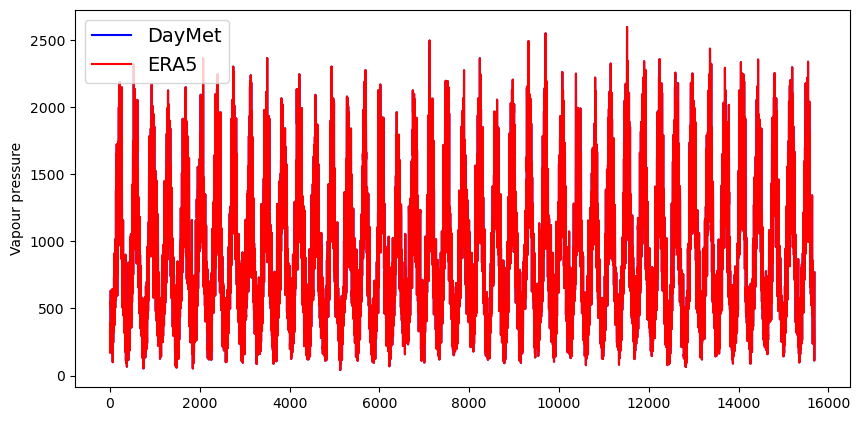

In [23]:
# Comparison EA 
xax = np.arange(0,len(ea_era_daily),1)
fig = plt.figure(figsize=(10,5), dpi=100)
plt.plot(xax, ea_daymet, 'b-', label = 'DayMet')
plt.plot(xax, ea_era_daily, 'r-', label = 'ERA5')

plt.legend(fontsize = 14)
#plt.ylim([-15, 30])
plt.ylabel('Vapour pressure')